In [1]:
import pandas as pd
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

In [41]:
goal_5a = "5.5.1-5.5.2.csv"
goal_5b = "5.6.1-5.6.2.csv"
COLUMNS = ["Goal", "Target", "Indicator", "SeriesDescription", "GeoAreaName", 
           "TimePeriod", "GeoAreaCode", "Value", "Units"]
INDICATORS = ["5.5.1", "5.5.2", "5.6.1", "5.6.2"]
LABEL = "Value"
INDICATOR = "Indicator"
TIME = "TimePeriod"
UNITS = "Units"
COUNTRY = "GeoAreaName"
CODE = "GeoAreaCode"
DESCR = "SeriesDescription"
YEARS = range(2013, 2022)
PRED_YEARS = [2022, 2023, 2024, 2025, 2026, 2027, 2028, 2029]

In [3]:
# Read in the 2 datafiles and sort by year, remove NaN values
df_5a = pd.read_csv(goal_5a)
df_5a = df_5a[COLUMNS].sort_values(TIME)
df_5a = df_5a[pd.to_numeric(df_5a[LABEL], errors = "coerce").notnull()]
df_5b = pd.read_csv(goal_5b)
df_5b = df_5b[COLUMNS].sort_values(TIME)
df_5b = df_5b[pd.to_numeric(df_5b[LABEL], errors = "coerce").notnull()]
df_lst = [df_5a, df_5b]

In [4]:
def dct_of_df(lst_df, lst_keys, key_col):
    """ given a list of dataframes, a list of keys, and the column in the 
        dataframes containing the keys, split the dataframe according 
        to the key and return a dictionary of dataframes 
    """
    df_indicators = {}
    low = 0
    high = 2
    for df in lst_df:
        for i in range(low, high):
            filtered = df[df[key_col] == lst_keys[i]]
            df_indicators[lst_keys[i]] = filtered
        low += 2
        high += 2
    return df_indicators

In [5]:
def find_avg_percent(years, df):
    """ given a list of years and a dataframe containing percentages 
        and numbers as metrics, find the average "PERCENT" per year. 
        Return the averages in a list
    """
    year_avgs = []
    for year in years:
        values_lst = []
        count = 0
        for j in range(len(df[LABEL])):
            if "PERCENT" in df.iloc[j][UNITS] and df.iloc[j][TIME] == year:
                value = float(df.iloc[j][LABEL])
                values_lst.append(value)
                count += 1
        avg = sum(values_lst) / count
        year_avgs.append(avg)
    return year_avgs

In [6]:
# create a dictionary of dataframes (with one dataframe (value) for each 
# indicator(key)) for each indicator, create a dataframe of average values
dct_dfs = dct_of_df(df_lst, INDICATORS, INDICATOR)
results_df = {}
for indicator in INDICATORS[0:3]:
    vals = find_avg_percent(YEARS, dct_dfs[indicator])
    results = {"Year": YEARS, LABEL: vals}
    results = pd.DataFrame.from_dict(results)
    results_df[indicator] = results

In [44]:
def avg_reg(years, values, indicator, title = "Global"):
    ''' Given a list of years and a list of average values, plot the change
        in average value over time and perform/plot a linear regression.
        Return the linear regression data
    '''
    X_vals = years
    y_vals = values
    plt.plot(X_vals, y_vals,"o", color = "deeppink", label = "UN Data")
    plt.title(f"{indicator} Values Over Time ({title}, {years[0]} - {years[len(years) - 1]})")
    plt.xlabel("Year")
    plt.ylabel("Average Percentage of Women (%)")
    reg = stats.linregress(X_vals, y_vals)
    y_pred = reg.intercept + reg.slope * np.array(X_vals)
    plt.plot(X_vals, y_pred, label = "Fitted Line", color = "maroon")
    plt.legend()
    plt.savefig(f"{indicator}.png")
    return reg

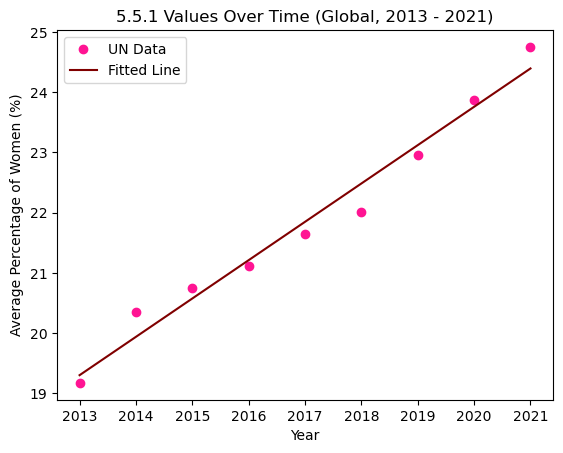

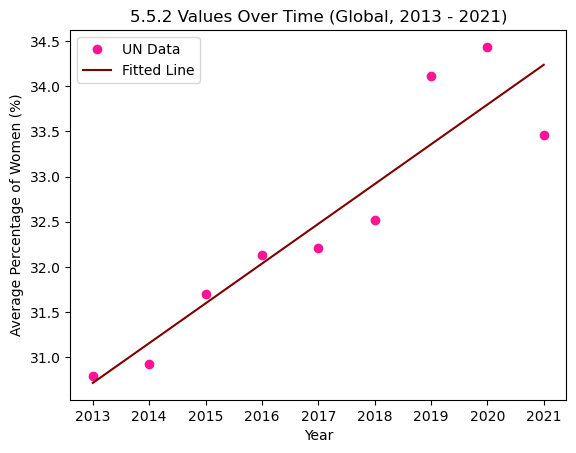

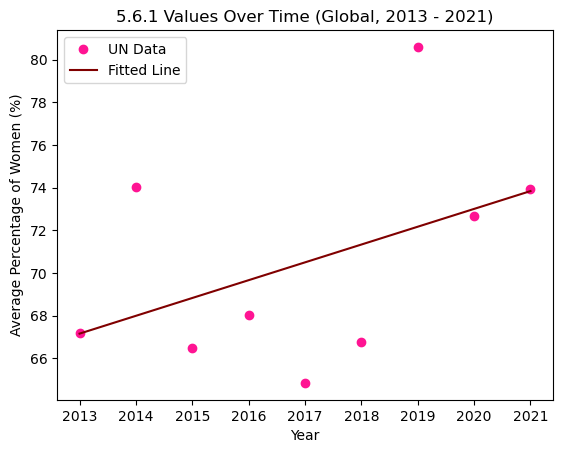

In [45]:
# For each indicator, create a plot of the change in average values over time
# (from the UN data) using a linear regression model
reg_dct = {}
for indicator in INDICATORS[0:3]:
    reg = avg_reg(YEARS, results_df[indicator][LABEL], indicator)
    reg_dct[indicator] = reg
    plt.show()

In [46]:
# Create a dictionary, where each indicator is a key and each value is a
# dataframe. In the dataframe: for each country, there is one indicator
# value per year
geo_dct = {}
for indicator in INDICATORS[0:3]:
    ind_df = dct_dfs[indicator].sort_values([DESCR, TIME, COUNTRY], 
                                            ascending = [False, True, True])
    ind_df = ind_df.drop_duplicates(subset = [TIME, COUNTRY])
    ind_df[f"Value {indicator}"] = ind_df[LABEL]
    ind_df = ind_df.drop(LABEL, axis = 1)
    geo_dct[indicator] = ind_df

In [47]:
# Merge the data for indicators 5.5.1 and 5.5.2
merged_df = pd.merge(geo_dct[INDICATORS[0]], geo_dct[INDICATORS[1]],  
                     left_on = [TIME, CODE], right_on = [TIME, CODE])
merged_df.head(5)

,Goal_x,Target_x,Indicator_x,SeriesDescription_x,GeoAreaName_x,TimePeriod,GeoAreaCode,Units_x,Value 5.5.1,Goal_y,Target_y,Indicator_y,SeriesDescription_y,GeoAreaName_y,Units_y,Value 5.5.2
0,5,5.5,5.5.1,Proportion of seats held by women in national ...,Albania,2013,8,PERCENT,15.71,5,5.5,5.5.2,Proportion of women in senior and middle manag...,Albania,PERCENT,29.3
1,5,5.5,5.5.1,Proportion of seats held by women in national ...,Algeria,2013,12,PERCENT,31.60,5,5.5,5.5.2,Proportion of women in managerial positions - ...,Algeria,PERCENT,10.6
2,5,5.5,5.5.1,Proportion of seats held by women in national ...,Argentina,2013,32,PERCENT,37.35,5,5.5,5.5.2,Proportion of women in senior and middle manag...,Argentina,PERCENT,36.49
3,5,5.5,5.5.1,Proportion of seats held by women in national ...,Armenia,2013,51,PERCENT,10.69,5,5.5,5.5.2,Proportion of women in managerial positions - ...,Armenia,PERCENT,28.8
4,5,5.5,5.5.1,Proportion of seats held by women in national ...,Australia,2013,36,PERCENT,24.67,5,5.5,5.5.2,Proportion of women in senior and middle manag...,Australia,PERCENT,32.87


In [48]:
def multiple_reg(df, features, label):
    ''' given a dataframe, a list of features, and a label column,
        perform a linear regression on the data 
        Return the predicted & actual values as a tuple
    '''
    X_train, X_test, y_train, y_test = train_test_split(df[features], df[label])
    lr = LinearRegression()
    lr.fit(X = X_train, y = y_train)
    predicted = lr.predict(X_test)
    predicted = predicted.tolist()
    actual = y_test.tolist()
    actual = [float(actual[i]) for i in range(len(actual))]
    return (predicted, actual)

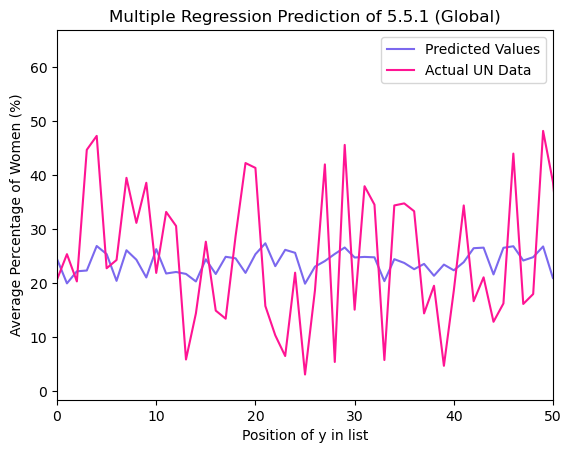

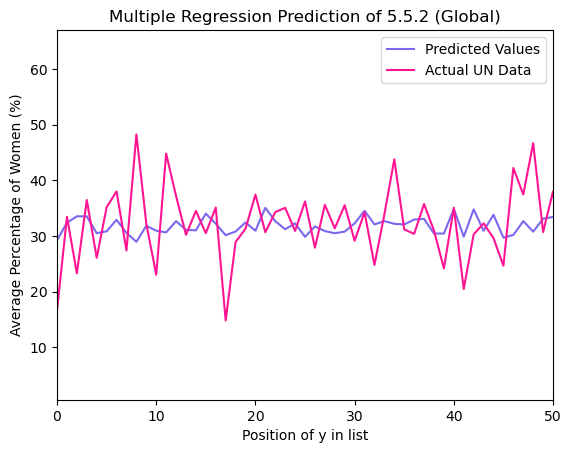

In [70]:
# For each indicator in goal 5.5, perform a multiple regression
# using the year, geo area code, and opposite indicator as features
# and the target indicator value as the label. 
# Plot the actual vs predicted values of the regression
mse_results = {}
for i in range(0, 2):
    ind_features = [TIME, CODE, f"Value {INDICATORS[abs(i - 1)]}"]
    ind_label = f"Value {INDICATORS[i]}"
    y_results = multiple_reg(merged_df, ind_features, ind_label)
    plt.plot(range(0, len(y_results[0])), y_results[0], color = "mediumslateblue", label = "Predicted Values")
    plt.plot(range(0, len(y_results[0])), y_results[1], color = "deeppink", label = "Actual UN Data")
    plt.title(f"Multiple Regression Prediction of {INDICATORS[i]} (Global)")
    plt.ylabel("Average Percentage of Women (%)")
    plt.xlabel("Position of y in list")
    plt.xlim(0, 50)
    plt.legend()
    plt.savefig(f"multi_regress_{INDICATORS[i]}.png")
    plt.show()

In [67]:
def avg_reg_country(years, values, indicator, future_yrs, title = "Global"):
    ''' Given a list of years and a list of average values, plot the change
        in average value over time and perform/plot a linear regression.
        Return the linear regression data
    '''
    X_vals = years
    y_vals = values
    country_reg = avg_reg(X_vals, y_vals, indicator, title)
    plt.title(f"{indicator} Values Over Time ({title}, {years[0]} - {future_yrs[len(future_yrs) - 1]})")
    future_pred = []
    for year in future_yrs:
        pred = country_reg.intercept + country_reg.slope * year
        future_pred.append(pred)
    plt.plot(future_yrs, future_pred, "o", label = "Prediction", color = "mediumslateblue")
    plt.legend()
    plt.savefig(f"{indicator}_{country}.png")
    plt.show()

Which country would you like to predict values for? Mexico


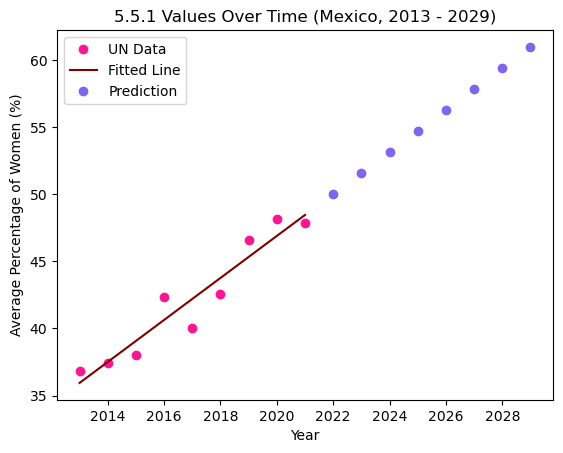

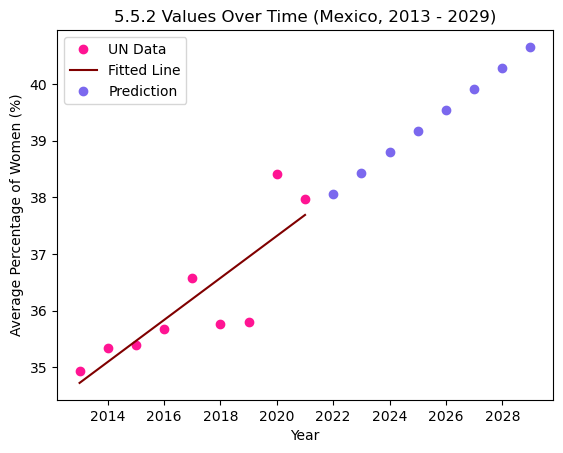

Which country would you like to predict values for? South Africa


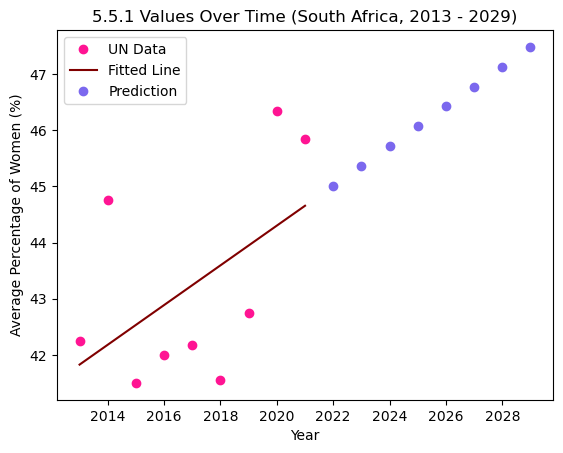

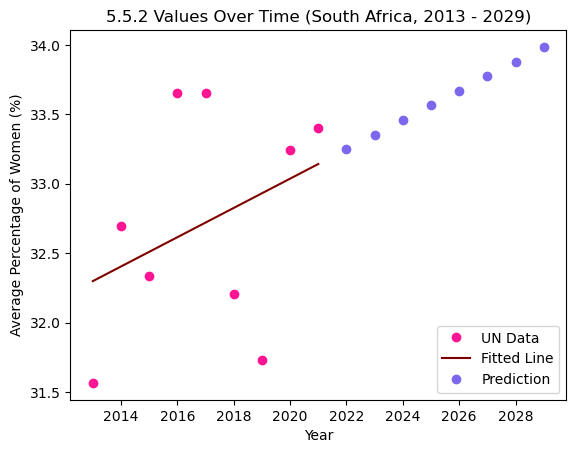

Which country would you like to predict values for? Philippines


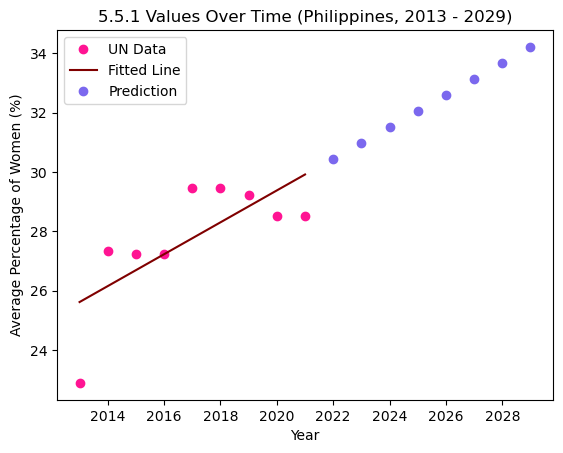

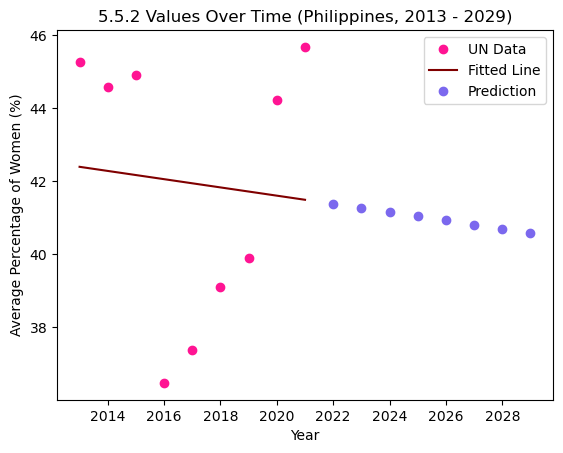

In [69]:
# Analyze hypotheses: Is the proportion of women in managerial/government
# positions expected to increase in 2024 & over the next 5 years (in developing countries)?
# Graph the linear regression of indicator values for current data of three developing
# nations, then use the model to predict the values up to year 2029
for i in range (0, 3):
    country = input("Which country would you like to predict values for?")
    country_dct = {}
    for indicator in INDICATORS[0:2]:
        df_country = dct_dfs[indicator][dct_dfs[indicator][COUNTRY] == country]
        country_avg = find_avg_percent(YEARS, df_country)
        results = {"Year": YEARS, LABEL: country_avg}
        results = pd.DataFrame.from_dict(results)
        country_dct[indicator] = results 
    for indicator in INDICATORS[0:2]:
        country_reg = avg_reg_country(YEARS, country_dct[indicator][LABEL], 
                                  indicator, PRED_YEARS, country)

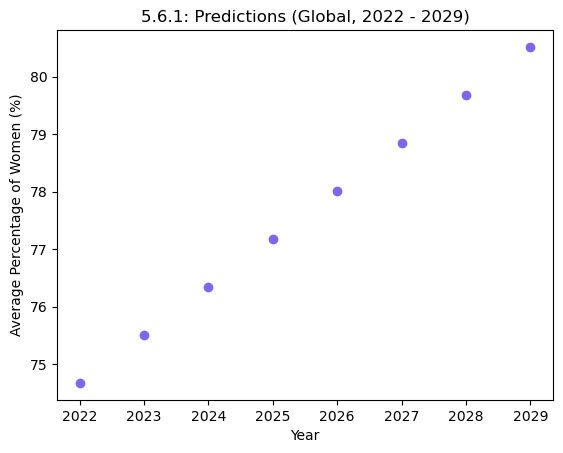

In [71]:
# Is the extent of laws guaranteeing equal access to health care, and sexual/reproductive 
# education expected to increase in 2024, and for the next five years? 
# Perform linear regression on indicator 5.6.1 to predict the average percentage of women 
# who are able to make informed decisions regarding sexual/reproductive health care globally
# Plot the predictions 
inf_decisions = reg_dct[INDICATORS[2]]
yr2_preds = []
for year in PRED_YEARS:
    yr_pred = inf_decisions.intercept + inf_decisions.slope * year
    yr2_preds.append(yr_pred)
plt.plot(PRED_YEARS, yr2_preds, "o", color = "mediumslateblue")
plt.title(f"{INDICATORS[2]}: Predictions (Global, {PRED_YEARS[0]} - {PRED_YEARS[len(PRED_YEARS) - 1]})")
plt.xlabel("Year")
plt.ylabel("Average Percentage of Women (%)")
plt.savefig("informed_dec.png")
plt.show()
